In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Dropout,Convolution2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
%matplotlib inline

In [0]:
num_classes = 5

#Building Model
model = Sequential()
#CONV=>CONV=>MAX
model.add(Convolution2D(32, (10, 10), input_shape=(250, 250, 3), activation='relu',padding='same'))
model.add(Convolution2D(32, (5, 5), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#CONV=>MAX
model.add(Convolution2D(64, (5, 5),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#CONV=>MAX
model.add(Convolution2D(200, (5, 5),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 250, 250, 32)      9632      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 250, 250, 32)      25632     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 125, 125, 64)      51264     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 62, 62, 200)       320200    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 31, 31, 200)      

In [0]:
WIDTH = 250
HEIGHT = 250
BATCH_SIZE = 16
train_data_dir=r'/content/drive/My Drive/data/train'

#DATA AUGMENTATION
train_datagen = ImageDataGenerator(
    samplewise_center=True,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.05 , 0.1],
    channel_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,#directory as training data
    target_size=(HEIGHT, WIDTH),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation') # set as validation data

Found 3249 images belonging to 5 classes.
Found 810 images belonging to 5 classes.


In [0]:
# Defining Keras callbacks

filepath = '/content/drive/My Drive/best_model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

Using TensorFlow backend.


In [0]:
#Training the model

epochs = 100

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n// BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.n// BATCH_SIZE,
    epochs = epochs,
    verbose=1,
    callbacks=[es, checkpoint]
    )

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 203 steps, validate for 50 steps
Epoch 1/100
202/203 [============================>.] - ETA: 6s - loss: 1.6005 - accuracy: 0.2310 
Epoch 00001: val_accuracy improved from -inf to 0.24625, saving model to /content/drive/My Drive/best_model.h5
203/203 [==============================] - 1712s 8s/step - loss: 1.5999 - accuracy: 0.2314 - val_loss: 1.5952 - val_accuracy: 0.2463
Epoch 2/100
202/203 [============================>.] - ETA: 0s - loss: 1.5954 - accuracy: 0.2390
Epoch 00002: val_accuracy did not improve from 0.24625
203/203 [==============================] - 90s 442ms/step - loss: 1.5954 - accuracy: 0.2385 - val_loss: 1.5859 - val_accuracy: 0.2463
Epoch 3/100
202/203 [============================>.] - ETA: 0s - loss: 1.5846 - accuracy: 0.2496
Epoch 00003: val_accuracy did not improve from 0.24625
203/203 [==============================] - 90s 442m

In [0]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

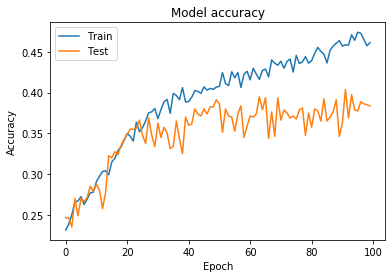

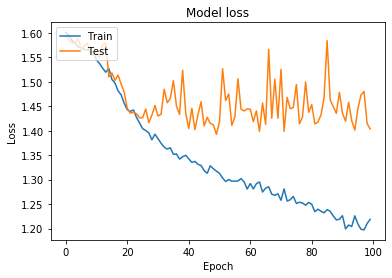

In [0]:
# Plot training & validation loss accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# TESTING

In [0]:
#Defining generator for the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_dir = '/content/drive/My Drive/data/validation'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(250, 250),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

Found 558 images belonging to 5 classes.


In [0]:
filenames = test_generator.filenames
nb_samples = len(filenames)

In [0]:
predict = model.predict_generator(test_generator,steps = nb_samples)

Instructions for updating:
Please use Model.predict, which supports generators.


In [0]:
predicted_classes = predict.argmax(axis=-1)

In [0]:
confusion_matrix(test_generator.classes, predicted_classes)

array([[74, 11,  5,  5,  7],
       [55, 16, 14, 14, 20],
       [35, 12, 23, 30, 50],
       [10,  1,  3, 16, 47],
       [ 4,  1,  3, 21, 81]])

In [0]:
print(classification_report(test_generator.classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.42      0.73      0.53       102
           1       0.39      0.13      0.20       119
           2       0.48      0.15      0.23       150
           3       0.19      0.21      0.20        77
           4       0.40      0.74      0.51       110

    accuracy                           0.38       558
   macro avg       0.37      0.39      0.33       558
weighted avg       0.39      0.38      0.33       558

